In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

以下のセルでEKF_Simulation_AllData.csvにカラム名を付与してください

In [5]:
column_names = [
    'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
    'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
    'u1_s', 'u2_s',  # s_uHistory
    'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
    'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
    'u1_l', 'u2_l'  # l_uHistory
]
df = pd.read_csv("data/EKF_Simulation_AllData_takami.csv", names=column_names, header=None)

In [6]:
df.to_csv("data/EKF_Simulation_AllData_takami.csv",index=False)

次に「use_makecop.m」を実行してcopを計算してください
次にdata\EKF_Simulation_AllData_with_COP.csvを使用してcomのデータを取得します

In [34]:
df = pd.read_csv("data/EKF_Simulation_AllData_takami_with_COP.csv")

system_params = {
    'm1': 28.00,   # Mass of the first segment (leg)
    'm2': 53.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.88,    # Length of the second segment (trunk)
    'com1': 0.58,  # Distance to CoM of the first segment
    'com2': 0.32,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Function to calculate CoM
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # Convert to radians
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # Calculate CoM positions
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    # Ensure it returns a Pandas Series with correct length
    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'],row['q2_s_true'], system_params), axis=1)
df[['com_x_l', 'com_z_l']] = df.apply(lambda row: calculate_com(row['q1_l_true'],row['q2_l_true'], system_params), axis=1)

df[['dcom_x_s', 'dcom_z_s']] = df[['com_x_s', 'com_z_s']].diff().fillna(0)
df[['dcom_x_l', 'dcom_z_l']] = df[['com_x_l', 'com_z_l']].diff().fillna(0)

df[['ddcom_x_s', 'ddcom_z_s']] = df[['dcom_x_s', 'dcom_z_s']].diff().fillna(0)
df[['ddcom_x_l', 'ddcom_z_l']] = df[['dcom_x_l', 'dcom_z_l']].diff().fillna(0)

df[['dCOP_s', 'dCOP_l']] = df[['COP_s', 'COP_l']].diff().fillna(0)
df[['ddCOP_s', 'ddCOP_l']] = df[['dCOP_s', 'dCOP_l']].diff().fillna(0)

In [21]:
df.to_csv("data/EKF_Simulation_AllData_takami_COP_COM.csv",index = False)

以下のセルでddqを作成します

In [26]:
def double_link_dynamics_takami(t, x, u, params):

    # Unpack parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']

    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Unpack states
    q1, q2, dq1, dq2 = x

    q1_new = q1 + np.pi / 2

    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    s1 = np.sin(q1_new)
    s2 = np.sin(q2)
    c1 = np.cos(q1_new)
    c2 = np.cos(q2)
    c12 = np.cos(q1_new + q2)

    # Compute the Mass Matrix (M)
    M11 = a + 2 * b * c2
    M12 = d + b * c2
    M = np.array([[M11, M12],
                  [M12, d]])

    # Compute the Coriolis Matrix (C)
    C = np.array([
        [-b * s2 * dq2, -b * s2 * (dq1 + dq2)],
        [b * s2 * dq2, 0]
    ])

    # Compute the Gravity Vector (G)
    G1 = -g * ((m1 * r1 + m2 * L1) * c1 + m2 * r2 * c12)
    G2 = -g * m2 * r2 * c12
    G = np.array([G1, G2])

    # Solve for angular accelerations
    ddq = np.linalg.solve(M + 1e-6 * np.eye(2), u - C @ np.array([dq1, dq2]) - G)

    # Return state derivatives
    dxdt = np.array([dq1, dq2, ddq[0], ddq[1]])

    return dxdt

x_data = df[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']].values
u_data = df[['u1_s', 'u2_s']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで
dxdt_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    dxdt = double_link_dynamics_takami(0, x_k, u_k_next, params)
    dxdt_list.append(dxdt)

# numpy 配列に変換（利便性のため）

dxdt_array = np.array(dxdt_list)
df_dxdt = pd.DataFrame(dxdt_list, columns=['dq1', 'dq2', 'ddq1', 'ddq2'])
df['ddq1_s_true'] = df_dxdt['ddq1']
df['ddq2_s_true'] = df_dxdt['ddq2']


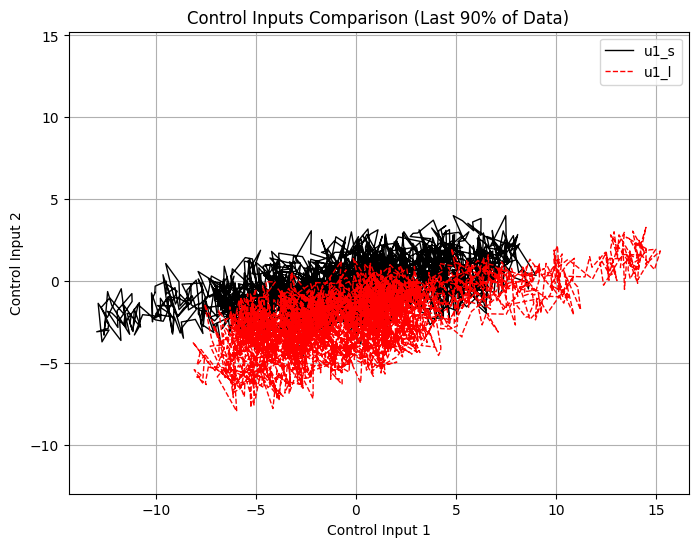

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# データフレーム df が存在することを確認してください
if 'df' in locals():
    # データの後半90%を取得
    start_index = int(len(df) * 0.2)  # 先頭10%をスキップ
    df_subset = df.iloc[start_index:]

    # データの取得
    u1_s = df_subset['u1_s'].values
    u2_s = df_subset['u2_s'].values
    u1_l = df_subset['u1_l'].values
    u2_l = df_subset['u2_l'].values

    # すべてのデータを結合して90%範囲を計算
    all_data = np.concatenate([u1_s, u2_s, u1_l, u2_l])
    percentile_5 = np.percentile(all_data, 0)
    percentile_95 = np.percentile(all_data, 100)

    # プロット
    plt.figure(figsize=(8, 6))
    plt.plot(u1_s, u2_s, label='u1_s', color="black", linewidth=1)
    plt.plot(u1_l, u2_l, label='u1_l', linestyle="--", color="r", linewidth=1)

    # y軸の範囲を設定（全体の90%のデータ範囲）
    plt.ylim(percentile_5, percentile_95)

    # ラベルと凡例
    plt.xlabel('Control Input 1')
    plt.ylabel('Control Input 2')
    plt.legend()
    plt.title('Control Inputs Comparison (Last 90% of Data)')

    # グリッド表示
    plt.grid(True)

    # グラフの表示
    plt.show()
else:
    print("データフレーム 'df' が存在しません。データを提供してください。")


Text(0, 0.5, 'u2(N.m)')

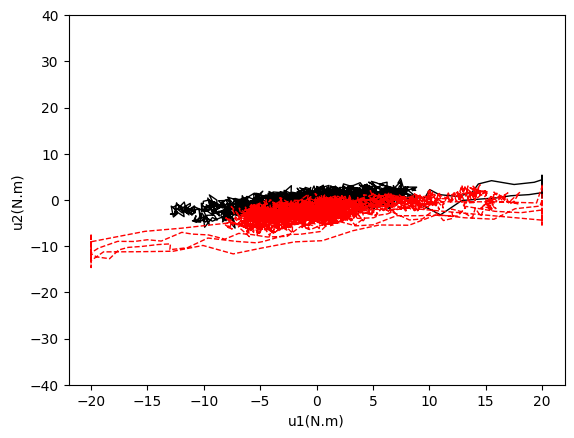

In [22]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)

plt.xlabel('u1(N.m)')
plt.ylabel('u2(N.m)')

Text(0, 0.5, 'u2(N.m)')

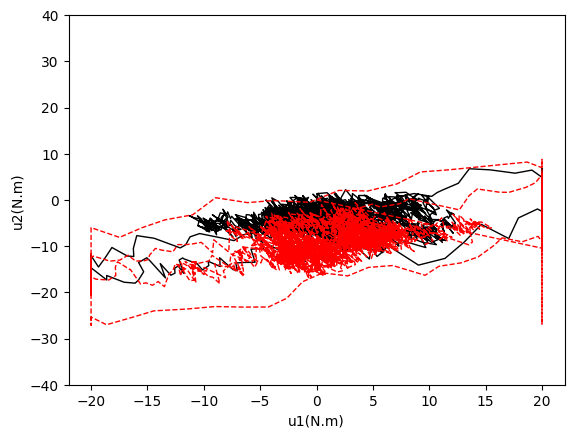

In [10]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)

plt.xlabel('u1(N.m)')
plt.ylabel('u2(N.m)')

In [11]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l'],
      dtype='object')

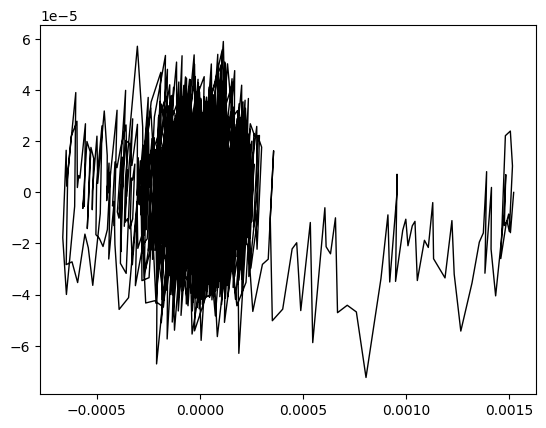

In [23]:
plt.plot(df['com_x_s'], df['dcom_x_s'], label='u1_s',color="black",linewidth=1)


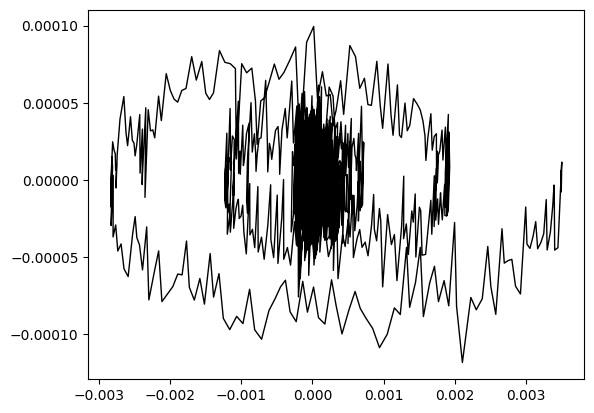

In [24]:
plt.plot(df['com_x_l'], df['dcom_x_l'], label='u1_s',color="black",linewidth=1)
# plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
# plt.ylim(-40, 40)

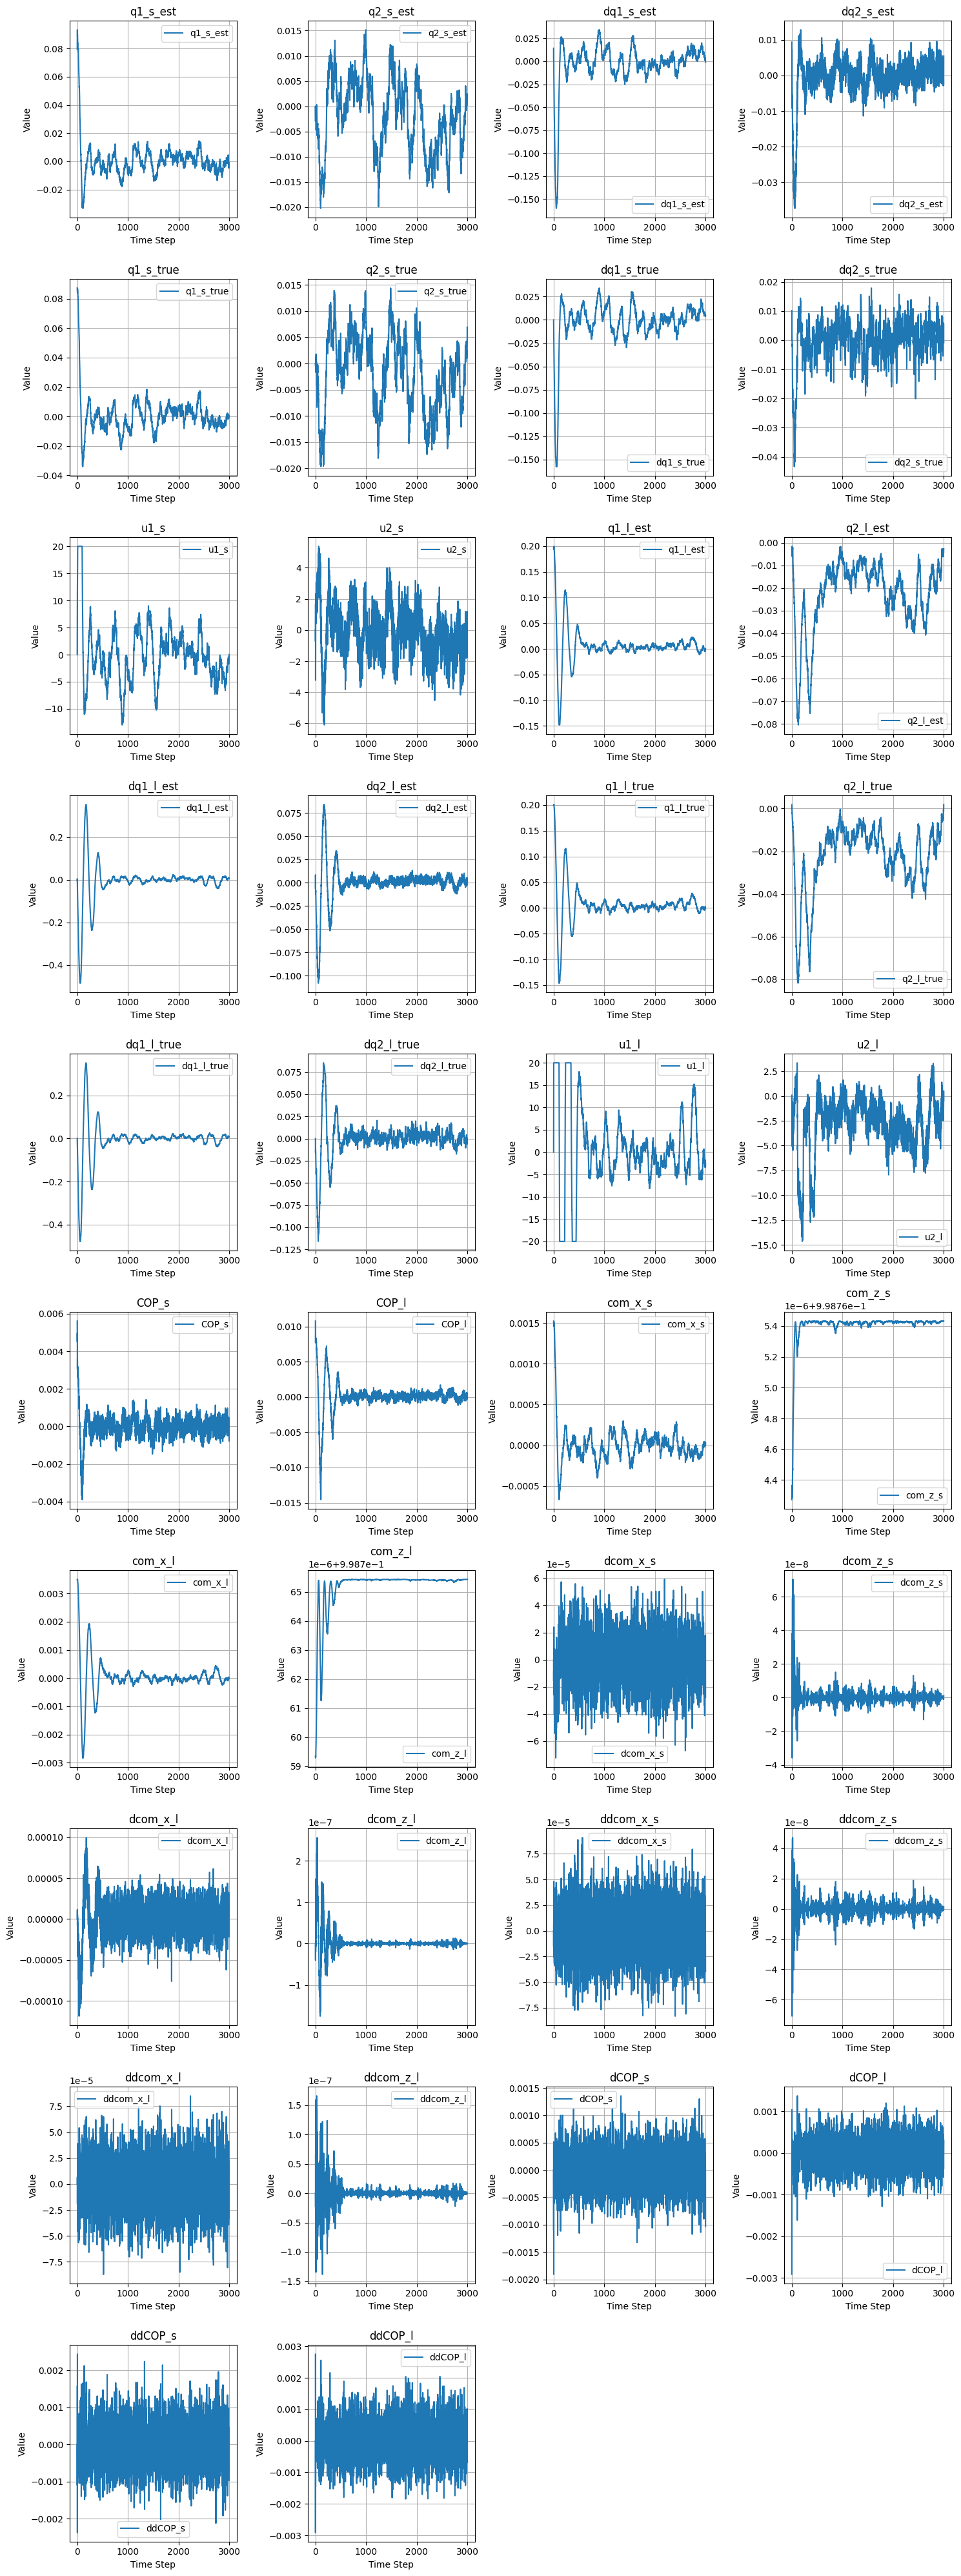

In [25]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()